In [14]:
from tqdm import tqdm 
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense, Activation, Embedding, concatenate, Input, Flatten, LSTM, TextVectorization
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Model 1

### Loading data

In [15]:
X = np.load("./x.npy", allow_pickle=True)
y = np.load("./y.npy", allow_pickle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Pre-process the input data

In [16]:
def address_split(x):
  vzfill = np.vectorize(np.char.zfill)
  x_PC = x[:, 0]
  x_PC = vzfill(x_PC, 8)
  x_PC = np.asarray(x_PC)
  x_addr = x[:, 1]
  x_addr = vzfill(x_addr, 12)
  x_addr_page = [x_addr[i][0:8] for i in range(0, x_addr.shape[0])]
  x_addr_page = np.asarray(x_addr_page)
  x_addr_offset = [x_addr[i][8:12] for i in range(0, x_addr.shape[0])]
  x_addr_offset = np.asarray(x_addr_offset)
  return x_PC, x_addr_page, x_addr_offset


In [17]:
X_train_PC, X_train_addr_page, X_train_addr_offset = address_split(X_train)
X_test_PC, X_test_addr_page, X_test_addr_offset = address_split(X_test)

In [18]:
unique, counts = np.unique(X_train_addr_page, return_counts=True)
unique_page_count = len(counts)
print("Unique page count is : " + str(unique_page_count))

unique, counts = np.unique(X_train_addr_offset, return_counts=True)
unique_offset_count = len(counts)
print("Unique offset count is : " + str(unique_offset_count))

unique, counts = np.unique(X_train_PC, return_counts=True)
unique_PC_count = len(counts)
print("Unique PC count is : " + str(unique_PC_count))

Unique page count is : 149
Unique offset count is : 3005
Unique PC count is : 21


In [19]:
x_train = [X_train_PC, X_train_addr_page, X_train_addr_offset]
x_test = [X_test_PC, X_test_addr_page, X_test_addr_offset]

In [20]:
page_input = Input(shape = (1,), dtype = tf.string)
page_vectorize_layer = TextVectorization(unique_page_count, output_mode = 'int', output_sequence_length = 1)
page_vectorize_layer.adapt(X_train_addr_page)
vectorized_page = page_vectorize_layer(page_input)
page_embedding = Embedding(unique_page_count, 20)(vectorized_page)
page_embedding = Flatten()(page_embedding)

offset_input = Input(shape = (1,), dtype = tf.string)
offset_vectorize_layer = TextVectorization(unique_offset_count, output_mode = 'int', output_sequence_length = 1)
offset_vectorize_layer.adapt(X_train_addr_offset)
vectorized_offset = offset_vectorize_layer(offset_input)
offset_embedding = Embedding(input_dim = unique_offset_count, output_dim = 20)(vectorized_offset)
offset_embedding = Flatten()(offset_embedding)

PC_input = Input(shape = (1,), dtype = tf.string)
PC_vectorize_layer = TextVectorization(unique_offset_count, output_mode = 'int', output_sequence_length = 1)
PC_vectorize_layer.adapt(X_train_PC)
vectorized_PC = PC_vectorize_layer(PC_input)
PC_embedding = Embedding(input_dim = unique_offset_count, output_dim = 20)(vectorized_PC)
PC_embedding = Flatten()(PC_embedding)


input_embdeding = concatenate([page_embedding, offset_embedding, PC_embedding])
output = Dense(3, activation = "sigmoid")(input_embdeding)
model = Model(inputs=[page_input, offset_input, PC_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_3 (TextVect  (None, 1)           0           ['input_4[0][0]']                
 orization)                                                                                 

In [21]:
learning_rate = 1e-3
epochs = 200
batch_size = 500

In [22]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', metrics=["categorical_accuracy"],
              optimizer=opt)
model.fit(x_train, y_train, epochs = epochs, batch_size=100)

Epoch 1/200
90/90 [==============================] - 1s 1ms/step - loss: 0.5561 - categorical_accuracy: 0.7985
Epoch 2/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3481 - categorical_accuracy: 0.9439
Epoch 3/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3147 - categorical_accuracy: 0.9439
Epoch 4/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3130 - categorical_accuracy: 0.9439
Epoch 5/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3130 - categorical_accuracy: 0.9439
Epoch 6/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3129 - categorical_accuracy: 0.9439
Epoch 7/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3131 - categorical_accuracy: 0.9439
Epoch 8/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3130 - categorical_accuracy: 0.9439
Epoch 9/200
90/90 [==============================] - 0s 1ms/step - loss: 0.3129 - categorical_accuracy: 0.9439
E

In [23]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
y_new = model.predict_on_batch(x_train)


Accuracy: 94.327825


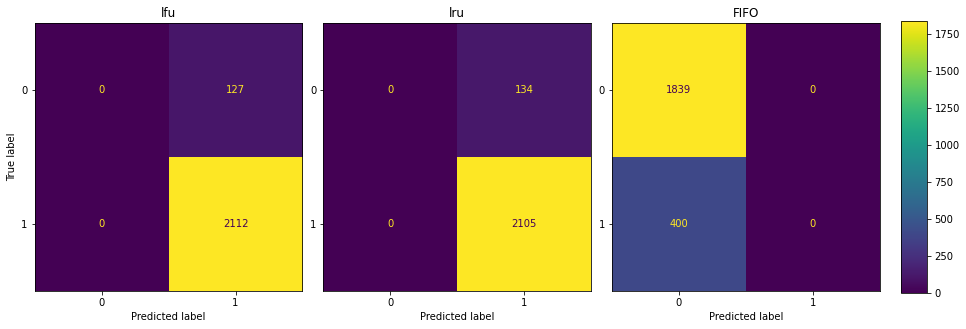

In [24]:
def confusion(test_data, model, ground_truth, labels):
  predicted = model.predict_on_batch(test_data)
  predicted = predicted >= 0.5
  labels = ['lfu', 'lru', 'FIFO']
  gridspec = {'width_ratios': [1, 1, 1, 0.1]}
  fig, axes = plt.subplots(1, 4, figsize=(16, 5), gridspec_kw=gridspec)
  axes = axes.ravel()

  for i in range(3):
    disp = ConfusionMatrixDisplay(confusion_matrix(ground_truth[:, i],
                                                    predicted[:, i]),
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(labels[i])
    disp.im_.colorbar.remove()
    if i !=0:
      disp.ax_.set_ylabel('')
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  fig.colorbar(disp.im_, cax=axes[3])
  plt.show()



labels = ['lfu', 'lru', 'FIFO']
confusion(x_test, model, y_test, labels)

In [25]:
import pandas as pd

df = pd.read_csv("./llc_access_trace.csv", sep=',')
df.columns = ['PC','Address']

In [26]:
from collections import deque, defaultdict

def hitRate(traces_pd, cache_size, model):
    cache = set()
    lru_recency = deque()
    lfu_frequency = defaultdict()
    fifo_order = deque()
    hit = 0
    miss = 0
    for i, row in tqdm(traces_pd.iterrows(), total=traces_pd.shape[0], leave = False):
        trace = row['Address']
         # Pop the visit position
        if trace in cache:
            hit += 1
            # update the lfu frequency
            lfu_frequency[trace] += 1
            # update the lfu 
            lru_recency.remove(trace)
            lru_recency.append(trace)
        elif len(cache) < cache_size:
            miss += 1
            cache.add(trace)
            # update the lfu
            lfu_frequency[trace] = 1
            # update the lru
            lru_recency.append(trace)
            # update the fifo
            fifo_order.append(trace)
        else:
            miss += 1
            # lfu propse a candidate
            lfu_candidate, f = min(lfu_frequency.items(), key=lambda a: a[1])
            # lru propose a candidate
            lru_candidate = lru_recency[0]
            # fifo propose a candidate
            fifo_candidate = fifo_order[0]
            candidates = [lfu_candidate, lru_candidate, fifo_candidate]
            # determine which one has the longest trace distance
            x_PC = row['PC']
            x_PC = x_PC.zfill(8)
            x_addr = row['Address']
            x_addr = x_addr.zfill(12)
            x_addr_page = x_addr[0:8]
            x_addr_offset = x_addr[8:12]
            x_addr_page = np.asarray([x_addr_page])
            x_addr_offset = np.asarray([x_addr_offset])
            x_PC = np.asarray([x_PC])
            predicted = model.predict_on_batch([x_PC, x_addr_page, x_addr_offset])
            evicted_candidate = candidates[np.argmax(predicted)]

            # update the cache
            cache.remove(evicted_candidate)
            cache.add(trace)

            # update the meta data
            # update the lru meta data
            lru_recency.remove(evicted_candidate)
            lru_recency.append(trace)
            # update the lfu meta data
            lfu_frequency.pop(evicted_candidate)
            lfu_frequency[trace] = 1
            # 
            fifo_order.remove(evicted_candidate)
            fifo_order.append(trace)
    return hit/(hit+miss)


df = pd.read_csv("./ChampSim/llc_access_trace.csv", sep=',')
df.columns = ['PC','Address']
df.head()


hitrate = hitRate(df,  2048, model)
